## To Do:
- Convert the non-gui implementation in main.py to use a gui
- Use [tkinter documentation](https://docs.python.org/3/library/tk.html)
- Implement the following features:
    - **Resize**
        - Prompt for a new image size
        - See [ezgif](https://ezgif.com/resize) for inspiration
    - **Timeline Scrubbing**
        - View edits as highlighted sections on the timeline
        - Multiple edits are shown in horizontal strips, stacked on top of each other, with identifying colors, text, and relevant info
        - Drag the edges of a strip to change the duration
    - **Edit Durations**
        - AKA KEYFRAMES
        - Input the number of frames a particular edit should be duplicated across.
    - **Edit Transitions**
        - AKA KEYFRAME TRANSITIONS
        - Global edits can be set to transition over a number of frames
        - Transition interpolations (Linear, Cosine, Cubic)
    - **Copy/Paste Selection**
        - Selections can be copy/pasted from a single frame to multiple frames, or continuously sampled from another section of the frame, every frame.
        - Click the tool icon
        - Drag or Click two points, A & B, to select a rectangle.
            - Hold CTRL+Drag to get a perfect square
        - Drag the corners to edit the selection
            - Edits to the selection bbox can be made as keyframes, or as timeline-wide edits.
        - Press Enter to Select
    - **Paint Tools**
        - Onion Skin Option
        - Brush Size, Opacity, 
    - **Select Ellipse**
        - Hold CTRL+Drag to get a perfect circle
    - **Select Lasso**
        - Drag the mouse around to select something
    - **Color Select**
        - Threshold
    - **HSL**
        - Hue, Saturation, Lightness
    - **BC**
        - Brightness, Contrast
    - **Color LUT**
    - **Import GIF with URL**
    - **Export GIF**
- Stretch Goals
    - 3D Animated Templates
        - Cube Spin
- Come up with more ideas for features; refer to a dumb non-moving image editor like MS Paint, or [Pixlr E](https://pixlr.com/e/) for inspiration.
- [Flixier](https://editor.flixier.com) is an online video editor with many features pertainent to moving images. See a demo of the software [here](https://www.youtube.com/watch?v=nFL08KtpXws)
- Blender has a fleshed-out video editing environment, refer to that once most basic features are implemented.

## Notes:
- Check docs on Pyinstaller to get more info on including asset files into the final .exe
    - The taskbar icon can only be set with Pyinstaller using ```pyinstaller --icon=icon.ico myscript.py```

## Testing Sandbox

### Example of binding events to tkinter.Canvas
Be aware: tkinter will not work when running the following code in the cloud. Use a local install of jupyter-lab.

In [ ]:
from tkinter import *
root = Tk()

Creating a new class for the interactive canvas

In [ ]:
class DrawCanvas(Canvas):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def paint(self, event):
        self.create_oval(event.x - 3, event.y - 3, event.x + 3, event.y + 3)

Initializing the newly extended canvas, packing it to the root, and binding the proper events to the canvas for painting:
- ```<1>``` Primary mouse button down 
- ```<B1-Motion>``` Motion of the mouse while the primary button is down  

See a full list of the tkinter events [here on effbot.org](https://web.archive.org/web/20201111211515id_/https://effbot.org/tkinterbook/tkinter-events-and-bindings.htm)

In [ ]:
c = DrawCanvas(root, width=300, height=300, bg='#E8D7F1')
c.pack(expand=True, fill='both')
c.bind('<1>', c.paint)
c.bind('<B1-Motion>', c.paint)
root.mainloop()

Try clicking and dragging the mouse on the new window!

### Attempting to make an opimized zoom function for GIFCanvas

In [5]:
from PIL import Image
import math

Timer function for displaying optimizations in a tangible way

In [60]:
import time
def timeit(func, *args, **kwargs):
  '''
  Stopwatch for any function
  '''
  start = time.time()
  out = func(*args, **kwargs)
  dt = time.time() - start
  return dt, out

The generator function for making a checkerboard grid as a specific zoom

In [71]:
# Generate a small section of background
def generate_tile(zoom=1, width=250, height=250):
  # Define grid colors
  lg = 255 // 2
  dg = 255 // 3

  # Starting by making a much smaller image
  # Making the grid cells the right size is done later using img.resize()
  # Using math.ceil so the dimensions are integers
  u_width = math.ceil(width / zoom)
  u_height = math.ceil(height / zoom)
  img = Image.new('RGB', (u_width, u_height), color=(dg, dg, dg))

  # Change every other pixel to get a checkboard
  pixels = img.load()
  k = 0
  for i in range(0, img.size[0]):
    for j in range(k, img.size[1], 2):
      pixels[i, j] = (lg, lg, lg)
    k = not k

  # Return the full size image, size rounded to fit grid cells evenly
  # Resampling with Image.BOX will not use any smoothing
  return img.resize((u_width * zoom, u_height * zoom), resample=Image.BOX)

Generated images look like a light grey & dark grey checkerboard grid, as seen in many photo editors

Time: 0.00333s (500, 250)


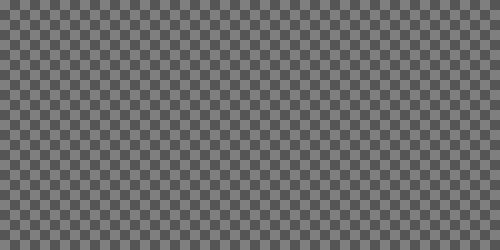

In [146]:
# Zoom is equivalent to the size of each grid cell in pixels
t, img = timeit(generate_tile, zoom=10, width=500, height=250)
print(f'Time: {round(t, 5)}s', img.size)
display(img)

#### Plotting the time taken to generate different sized tiles

In [135]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import style
style.use('dark_background')

# rc is necessary to play animations in python notebooks
from matplotlib import rc
rc('animation', html='jshtml')

The following method will graph the efficiency of any grid generation function that takes the parameters:  
```(width: int, height: int: zoom: int)```

In [144]:
def test_generation_time(func):
  '''
  func: The generation function to be tested
  Parameters of func MUST be the following
  (width: int, height: int, zoom: int)

  For maximum stress, the zoom is fixed at the minimum of 1
  '''
  fig = plt.figure()
  ax = plt.axes()

  x = []
  y = []

  def animate(i, step):
    ax.clear()

    plt.title('Calculation time of generate_tile()')
    ax.set_xlabel('Pixels Generated')
    ax.set_ylabel('Time Taken (s)')

    v = i * step
    x.append(v**2)
    t, _img = timeit(func, width=v, height=v, zoom=1)
    y.append(t)
    p = ax.plot(x, y)
    a, b = np.polyfit(x, y, 1)
    l, = ax.plot(x, a*np.array(x)+b)
    l.set_label(f'Slope: {a}')
    ax.legend()
    return p

  p = None
  for i in range(1, 50):
    p = animate(i, 20)
  p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned


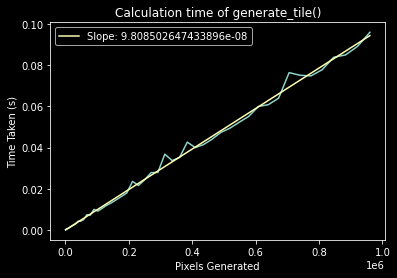

In [145]:
test_generation_time(generate_tile)

From the plot as can see that there is a linear relationship between the number of pixels generated and the time taken to generate. Keeping generation time low is imperative, so testing other methods may be useful.